# Import Libraries

In [28]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# Load Dataset

In [29]:
train_df = pd.read_csv("train.csv")
test_df = pd.read_csv("test.csv")
gender_df = pd.read_csv("gender_submission.csv")

# Show data

In [30]:
print("Train shape:", train_df.shape)
print("Test shape:", test_df.shape)

train_df.head()

Train shape: (891, 12)
Test shape: (418, 11)


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


# Handeling missing values

In [31]:
from sklearn.impute import SimpleImputer


# Impute Age with median
age_imputer = SimpleImputer(missing_values=np.nan, strategy="median")
train_df["Age"] = age_imputer.fit_transform(train_df[["Age"]])

# Impute Embarked with most frequent (mode)
embarked_imputer = SimpleImputer(strategy="most_frequent")
train_df["Embarked"] = embarked_imputer.fit_transform(train_df[["Embarked"]]).ravel()

train_df = train_df.drop(columns=["Cabin"])

train_df.isnull().sum()



,0
PassengerId,0
Survived,0
Pclass,0
Name,0
Sex,0
Age,0
SibSp,0
Parch,0
Ticket,0
Fare,0


In [32]:
# Features and target
# Drop columns that are not useful
X = train_df.drop(["Survived", "Name", "Ticket"], axis=1)
y = train_df["Survived"]


# Encoding Categorical Data

In [33]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
import numpy as np



# Apply OneHotEncoder to categorical columns (Sex and Embarked)
ct = ColumnTransformer(
    transformers=[("encoder", OneHotEncoder(), ["Sex", "Embarked"])],
    remainder="passthrough"
)

X = np.array(ct.fit_transform(X))



# Splitting the dataset into training set and test set


In [43]:

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)


# Training model without scaling and with scaling too

In [35]:
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report

# ---------------- Logistic Regression (with scaling) ----------------
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

log_reg = LogisticRegression(max_iter=1000)
log_reg.fit(X_train_scaled, y_train)
y_pred_lr = log_reg.predict(X_test_scaled)

print("🔹 Logistic Regression Results:")
print("Accuracy:", accuracy_score(y_test, y_pred_lr))
print(classification_report(y_test, y_pred_lr))

# ---------------- Random Forest (without scaling) ----------------
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)

print("\n🔹 Random Forest Results:")
print("Accuracy:", accuracy_score(y_test, y_pred_rf))
print(classification_report(y_test, y_pred_rf))


🔹 Logistic Regression Results:
Accuracy: 0.8044692737430168
              precision    recall  f1-score   support

           0       0.82      0.85      0.84       105
           1       0.77      0.74      0.76        74

    accuracy                           0.80       179
   macro avg       0.80      0.80      0.80       179
weighted avg       0.80      0.80      0.80       179


🔹 Random Forest Results:
Accuracy: 0.8324022346368715
              precision    recall  f1-score   support

           0       0.84      0.88      0.86       105
           1       0.81      0.77      0.79        74

    accuracy                           0.83       179
   macro avg       0.83      0.82      0.83       179
weighted avg       0.83      0.83      0.83       179



# Hyperparameter Tuning for Logistic Regression

We’ll use GridSearchCV

In [36]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression

# Define parameter grid
param_grid = {
    'C': [0.01, 0.1, 1, 10, 100],   # Regularization strength
    'solver': ['liblinear', 'saga'], # Optimizers
    'penalty': ['l1', 'l2']          # Regularization type
}

# Create model
log_reg = LogisticRegression(max_iter=1000)

# Grid search
grid_search_log = GridSearchCV(estimator=log_reg,
                               param_grid=param_grid,
                               cv=5,
                               scoring='accuracy',
                               n_jobs=-1)

grid_search_log.fit(X_train_scaled, y_train)

print("Best parameters for Logistic Regression:", grid_search_log.best_params_)
print("Best cross-validation score:", grid_search_log.best_score_)


Best parameters for Logistic Regression: {'C': 0.1, 'penalty': 'l2', 'solver': 'saga'}
Best cross-validation score: 0.8019107652910469


# Hyperparameter Tuning for Random Forest

Here RandomizedSearch is faster.

In [37]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV

# Define parameter grid
param_dist = {
    'n_estimators': [100, 200, 300, 500],
    'max_depth': [None, 5, 10, 15, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}

# Create model
rf = RandomForestClassifier(random_state=42)

# Randomized search
random_search_rf = RandomizedSearchCV(estimator=rf,
                                      param_distributions=param_dist,
                                      n_iter=20,        # number of random combos to try
                                      cv=5,
                                      scoring='accuracy',
                                      random_state=42,
                                      n_jobs=-1)

random_search_rf.fit(X_train, y_train)

print("Best parameters for Random Forest:", random_search_rf.best_params_)
print("Best cross-validation score:", random_search_rf.best_score_)


Best parameters for Random Forest: {'n_estimators': 100, 'min_samples_split': 10, 'min_samples_leaf': 1, 'max_depth': 5, 'bootstrap': False}
Best cross-validation score: 0.8229981286319316


# Evaluation

In [38]:
from sklearn.metrics import accuracy_score

# Retrain with best parameters
best_log_reg = LogisticRegression(**grid_search_log.best_params_, max_iter=1000)
best_log_reg.fit(X_train_scaled, y_train)

# Predictions
y_pred_log = best_log_reg.predict(X_test_scaled)

# Accuracy
print("Logistic Regression Test Accuracy:", accuracy_score(y_test, y_pred_log))


Logistic Regression Test Accuracy: 0.7932960893854749


In [39]:
# Retrain with best parameters
best_rf = RandomForestClassifier(**random_search_rf.best_params_, random_state=42)
best_rf.fit(X_train, y_train)

# Predictions
y_pred_rf = best_rf.predict(X_test)

# Accuracy
print("Random Forest Test Accuracy:", accuracy_score(y_test, y_pred_rf))


Random Forest Test Accuracy: 0.8044692737430168


=== Logistic Regression Report ===
              precision    recall  f1-score   support

           0       0.81      0.85      0.83       105
           1       0.77      0.72      0.74        74

    accuracy                           0.79       179
   macro avg       0.79      0.78      0.78       179
weighted avg       0.79      0.79      0.79       179

=== Random Forest Report ===
              precision    recall  f1-score   support

           0       0.80      0.89      0.84       105
           1       0.81      0.69      0.74        74

    accuracy                           0.80       179
   macro avg       0.81      0.79      0.79       179
weighted avg       0.80      0.80      0.80       179



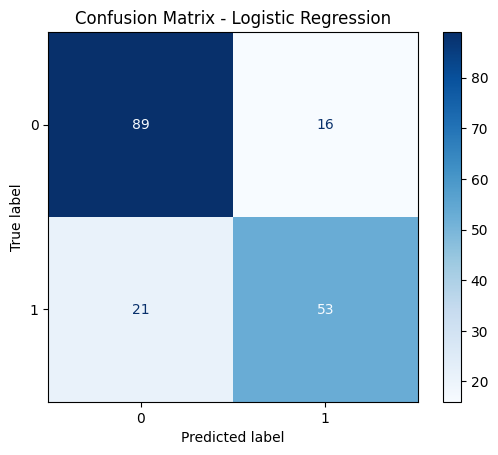

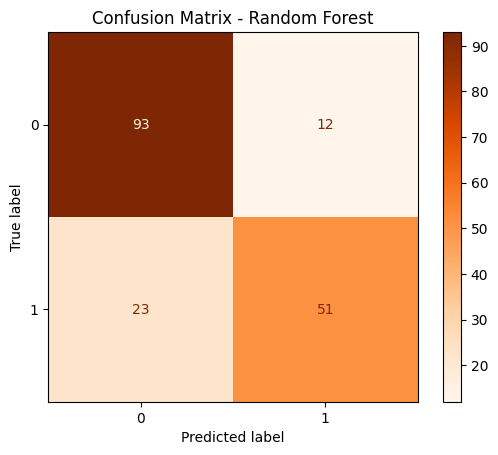

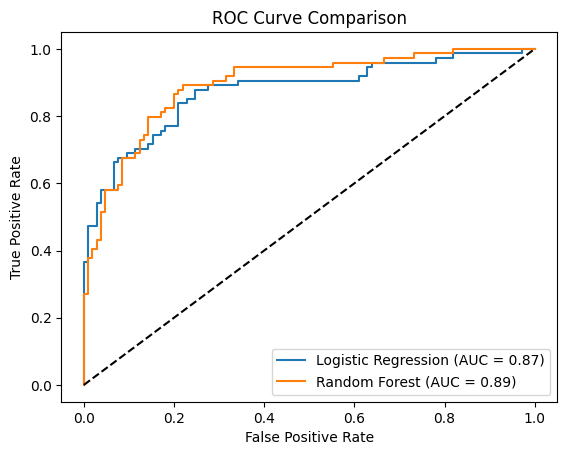

In [40]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc
import matplotlib.pyplot as plt

# Logistic Regression Report
print("=== Logistic Regression Report ===")
print(classification_report(y_test, y_pred_log))

# Random Forest Report
print("=== Random Forest Report ===")
print(classification_report(y_test, y_pred_rf))

# Confusion Matrix - Logistic Regression
cm_log = confusion_matrix(y_test, y_pred_log)
disp_log = ConfusionMatrixDisplay(confusion_matrix=cm_log, display_labels=best_log_reg.classes_)
disp_log.plot(cmap="Blues")
plt.title("Confusion Matrix - Logistic Regression")
plt.show()

# Confusion Matrix - Random Forest
cm_rf = confusion_matrix(y_test, y_pred_rf)
disp_rf = ConfusionMatrixDisplay(confusion_matrix=cm_rf, display_labels=best_rf.classes_)
disp_rf.plot(cmap="Oranges")
plt.title("Confusion Matrix - Random Forest")
plt.show()

# ROC Curve comparison
y_prob_log = best_log_reg.predict_proba(X_test_scaled)[:,1]
y_prob_rf = best_rf.predict_proba(X_test)[:,1]

fpr_log, tpr_log, _ = roc_curve(y_test, y_prob_log)
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_prob_rf)

roc_auc_log = auc(fpr_log, tpr_log)
roc_auc_rf = auc(fpr_rf, tpr_rf)

plt.plot(fpr_log, tpr_log, label=f"Logistic Regression (AUC = {roc_auc_log:.2f})")
plt.plot(fpr_rf, tpr_rf, label=f"Random Forest (AUC = {roc_auc_rf:.2f})")
plt.plot([0,1], [0,1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve Comparison")
plt.legend()
plt.show()
